# AOS_comCam_donut_single

Generate single donut per chip for AOS testing 

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams 
import matplotlib.patheffects as path_effects

from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.table import Table

import run_ps1_functions as func 

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay

from lsst.obs.lsst import LsstComCam
camera = LsstComCam().getCamera()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


xPx = np.zeros(0)
yPx = np.zeros(0)
sensorsAll = list(camera.getNameMap().keys())

ra, dec, xPx, yPx = func.ccd_xy_to_radec(x_px=[2000], y_px=[2000], 
                                               boresight_ra=0, boresight_dec=0, 
                                                rotskypos=0, sensorNameList = sensorsAll)
        

In [15]:
import imp
imp.reload(func)
# make an inst catalog 
coords = Table(data=[ra, dec],  names=['ra','dec'])

# add a column with object id 
coords['objid'] = np.arange(len(coords))
#coords['g'] = [starMag for x in range(len(coords))]

starMag=14
mjd = 57648  # arbitrary observation date 
obsid = 9007777

# make separate catalogs for extra and intra movements
for position in ['extra','intra']:
    outDir = '/project/scichris/aos/images/comCam/'
    phosimFile=f'comCam_single_donut_{position}.inst'
    
    func.writePhosimInstFile(coords, ra=0, dec=0, rotskypos=0 , 
                    phosimFile=phosimFile,  
                    outDir=outDir,
                    passband='g', mjd=mjd, exposure=15, obsid=obsid, 
                    position=position, 
                    constMag=starMag )
    obsid += 1 

Saved as  /project/scichris/aos/images/comCam/comCam_single_donut_extra.inst
Saved as  /project/scichris/aos/images/comCam/comCam_single_donut_intra.inst


Run phosim, executing on `lsst-devl02` : 
    
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

    cd /project/scichris/aos/images/comCam
    
First, extra-focal :

    mkdir single_donut_extra
    mkdir single_donut_extra/raw

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/comCam/comCam_single_donut_extra.inst -i comcam -e 1 -c /project/scichris/aos/images/comCam/noBkgnd.cmd -p 25  -o /project/scichris/aos/images/comCam/single_donut_extra/raw/ > /project/scichris/aos/images/comCam/single_donut_extra/starPhoSimLetter.log 2>&1

    setup -k -r /project/scichris/aos/phosim_utils/

    phosim_repackager.py /project/scichris/aos/images/comCam/single_donut_extra/raw/ --out_dir /project/scichris/aos/images/comCam/single_donut_extra/repackaged/ --inst comcam  --focusz -1500

    cd single_donut_extra
    cp ../letter/runIsr.sh .
    cp ../letter/testPipeline.yaml .

    ./runIsr.sh    

Then intra-focal:

    cd /project/scichris/aos/images/comCam
    
    mkdir single_donut_intra
    mkdir single_donut_intra/raw

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/images/comCam/comCam_single_donut_intra.inst -i comcam -e 1 -c /project/scichris/aos/images/comCam/noBkgnd.cmd -p 25  -o /project/scichris/aos/images/comCam/single_donut_intra/raw/ > /project/scichris/aos/images/comCam/single_donut_intra/starPhoSimLetter.log 2>&1

    setup -k -r /project/scichris/aos/phosim_utils/
    
    phosim_repackager.py /project/scichris/aos/images/comCam/single_donut_intra/raw/ --out_dir /project/scichris/aos/images/comCam/single_donut_intra/repackaged/ --inst comcam  --focusz 1500 


    cp ../letter_R22/runIsr.sh .
    cp ../letter_R22/testPipeline.yaml .

    ./runIsr.sh    

Show the results:

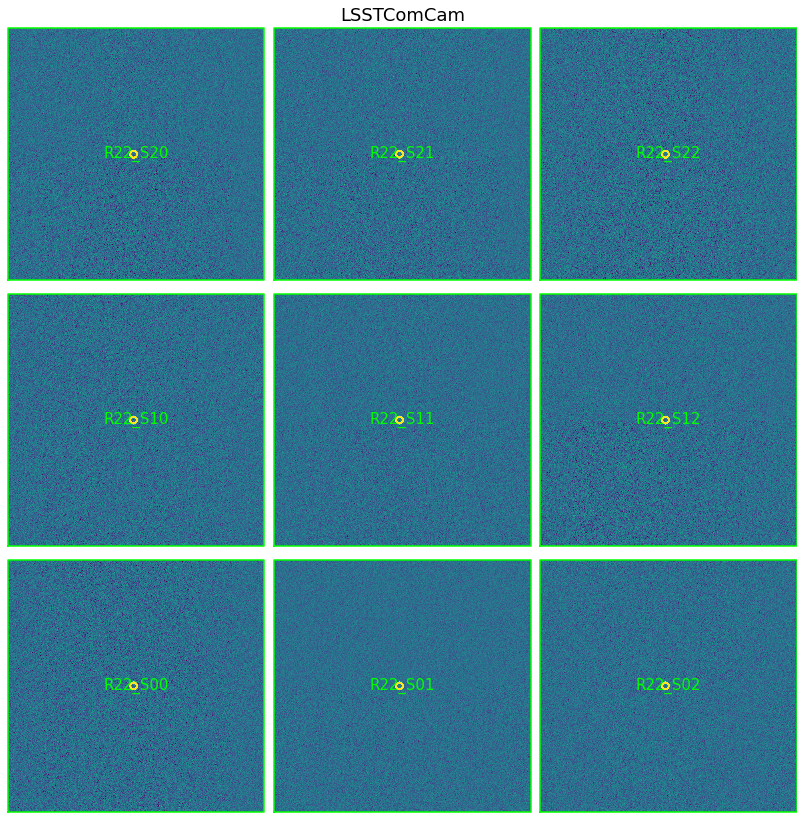

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

repo_dir = '/project/scichris/aos/images/comCam/single_donut_extra/DATA'
mos = func.plot_cameraGeom(repo_dir = repo_dir, detectorNameList=None,
                          instrument='LSSTComCam', binSize=1)  # in DVCS 

Very short exposure, so not too many counts for a 15th mag star:

(array([7.1480e+03, 4.7240e+03, 4.1880e+03, 4.7750e+03, 7.9200e+03,
        1.9352e+04, 3.2649e+04, 1.8234e+04, 1.3900e+03, 4.0000e+00]),
 array([ 100.,  240.,  380.,  520.,  660.,  800.,  940., 1080., 1220.,
        1360., 1500.], dtype=float32),
 <BarContainer object of 10 artists>)

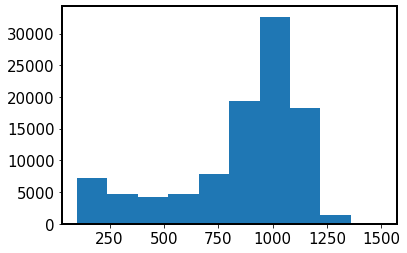

In [4]:
plt.hist(np.ravel(mos.array),range=(100,1500))

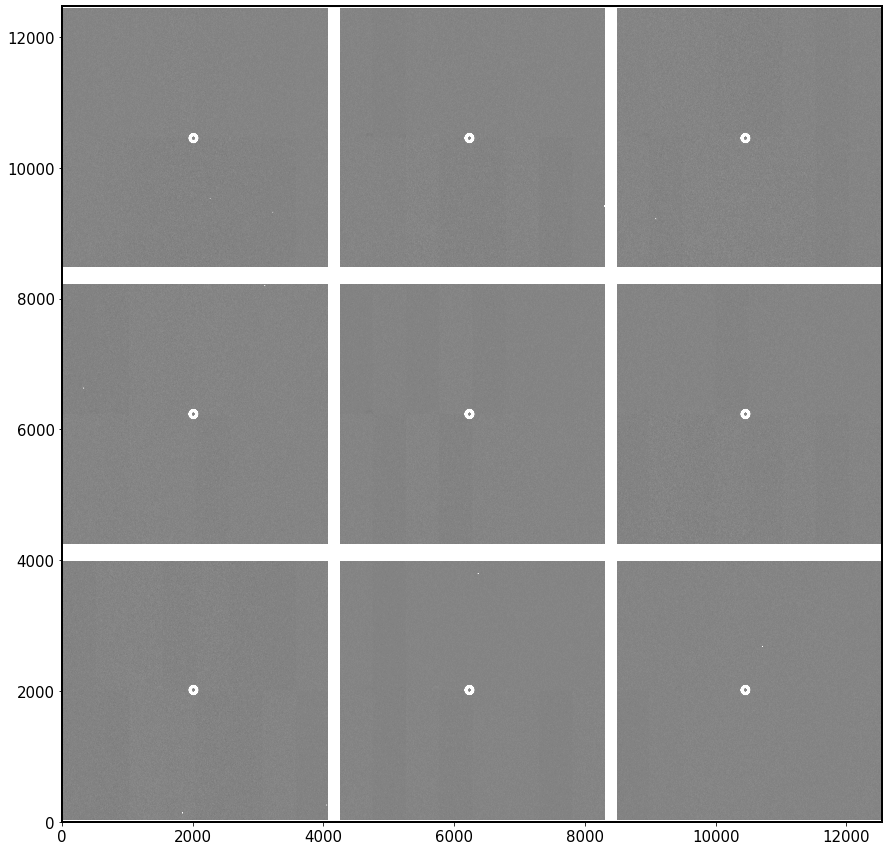

In [7]:
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(mos.array)

# in CCS 
# ax.imshow(mos.array.T, origin='lower', vmax=vmax, vmin=vmin,cmap='gray')
# plt.savefig(f'{instr}_{field}_{position}_Pert05_qck.png', bbox_inches='tight', )

fig,ax = plt.subplots(1,1,figsize=(15,15))
# in DVCS so it does not cause confusion... 
ax.imshow(mos.array, origin='lower', vmax=vmax, vmin=vmin,cmap='gray')